# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std


test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets

# federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader
#     datasets.CIFAR100('/home/zhaojia-raoxy/data', train=True, download=True,
#                    transform=train_transforms)
#     .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
#     batch_size=20, shuffle=True, **kwargs)


# federated_test_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader
#     datasets.CIFAR100('/home/zhaojia-raoxy/data', train=False, download=True,
#                    transform=test_transforms)
#     .federate((secure_worker_a, secure_worker_b)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
#     batch_size=20, shuffle=False, **kwargs)

In [4]:
federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# LeNet

In [5]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

model = LeNet(channel=3, hideen=768, num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03) # TODO momentum is not supported at the moment

# 训练

In [6]:
criterion = nn.CrossEntropyLoss().to(device)

In [7]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [8]:
loss_train=[]
acc_train=[]
def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
#         model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        n += target.shape[0]
        loss = criterion(output, target.long())
#         loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         model.get() # <-- NEW: get the model back
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print("{}\t{}".format(correct,target.shape))
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
     100.*correct / n))

In [9]:
for epoch in range(500):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 2.3108, Accuracy: 5052/50000 (10%)
Test set: Average loss: 2.3074, Accuracy: 1000/10000 (10%)
Train set: Average loss: 2.3089, Accuracy: 5099/50000 (10%)
Test set: Average loss: 2.3079, Accuracy: 1000/10000 (10%)
Train set: Average loss: 2.3080, Accuracy: 4959/50000 (10%)
Test set: Average loss: 2.3068, Accuracy: 1000/10000 (10%)
Train set: Average loss: 2.3065, Accuracy: 5020/50000 (10%)
Test set: Average loss: 2.3068, Accuracy: 1007/10000 (10%)
Train set: Average loss: 2.3054, Accuracy: 4974/50000 (10%)
Test set: Average loss: 2.3051, Accuracy: 1000/10000 (10%)
Train set: Average loss: 2.3046, Accuracy: 5012/50000 (10%)
Test set: Average loss: 2.3032, Accuracy: 1009/10000 (10%)
Train set: Average loss: 2.3039, Accuracy: 5032/50000 (10%)
Test set: Average loss: 2.3024, Accuracy: 982/10000 (10%)
Train set: Average loss: 2.3023, Accuracy: 5216/50000 (10%)
Test set: Average loss: 2.3021, Accuracy: 1000/10000 (10%)
Train set: Average loss: 2.2990, Accuracy: 5854/5

# 结果保存

In [10]:
save_name='LeNet-no-fed'

In [11]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/LeNet-no-fed.pt


In [12]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/LeNet-no-fed.h5


/home/zhaojia-raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 分析

In [64]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

In [66]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/zhaojia-raoxy/files/{}".format(save_name),index=False)

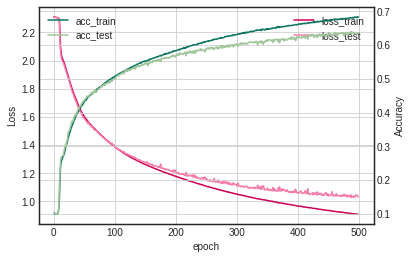

In [73]:
mpl.use('svg')
mpl.style.use('seaborn-white')

# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)

# 显示图形
# plt.show()

In [40]:
# def plotP(test_loss, train_loss, train_acc_list, test_acc_list):
#     plt.figure(figsize=(6, 8))
    
#     x = list(range(len(train_loss)))
#     y = list(range(len(test_acc_list)))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(x, train_loss, label="train_loss")
#     plt.plot(x, test_loss, label="test_loss")

#     plt.xlabel("epoch")
#     plt.ylabel("loss")
#     plt.legend()
#     plt.subplot(2, 1, 2)
#     plt.plot(y, train_acc_list, label="train_acc")
#     plt.plot(y, test_acc_list, label="test_acc")
#     plt.xlabel("epoch")
#     plt.ylabel("acc")
#     plt.legend()
#     plt.show()

# plotP(loss_test,loss_train, acc_train, acc_test)